In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.lines as mlines
import seaborn as sns
from statsmodels.stats import multitest
import gem_tools
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']

In [3]:
groupdict = {
    'm-control': ('all_control', 'MSBB'),
    'm-AD-A': ('SubtypeA_AD', 'MSBB'),
    'm-AD-B1': ('SubtypeB1_AD', 'MSBB'),
    'm-AD-B2': ('SubtypeB2_AD', 'MSBB'),
    'm-AD-C1': ('SubtypeC1_AD', 'MSBB'),
    'm-AD-C2': ('SubtypeC2_AD', 'MSBB'),
    'm-AD': ('nosubtyping_AD', 'MSBB'),
    'r-control': ('all_control', 'ROSMAP'),
    'r-AD-A': ('SubtypeA_AD', 'ROSMAP'),
    'r-AD-B': ('SubtypeB_AD', 'ROSMAP'),
    'r-AD-C1': ('SubtypeC1_AD', 'ROSMAP'),
    'r-AD-C2': ('SubtypeC2_AD', 'ROSMAP'),
    'r-AD-other': ('Other_AD', 'ROSMAP'),
    'r-AD': ('nosubtyping_AD', 'ROSMAP'),
}

Take the coefficient of variation (CV) of the odds ratio (OR) across all subtypes, where $\mathrm{OR}\in \mathbb{R}$

In [4]:
def read_fisher_csv(AD_subtype, cohort='m'):
    prefix = '../../results/2023-02-06-AD-subtypes-active-reactions/fisher-exact-'
    fpath = prefix + AD_subtype + '_wrt_' + cohort + '-control.csv'
    df = pd.read_csv(fpath, index_col='rxn_ID')
    AD_subtype = AD_subtype + '-all' if re.match(cohort + '-AD$', AD_subtype) else AD_subtype
    df.columns = pd.MultiIndex.from_product([[AD_subtype], df.columns])
    return(df)

def get_specificity_score_I(s):
    abs_of_sum = abs(s.dropna().sum())
    sum_of_abs = s.dropna().apply(abs).sum()
    specificity = 1 - abs_of_sum / sum_of_abs
    return(specificity)

def get_CV(s):
    ssdev = s.std(skipna=True) # sample std dev
    avg = s.mean(skipna=True)
    CV = ssdev / abs(avg)
    return(CV)

def AD_df(cohort='m', groupdict=groupdict):
    l = [read_fisher_csv(g, cohort=cohort) for g in groupdict.keys() if re.match(cohort + '-AD.*', g)]
    df = pd.concat(l, axis=1)
    return(df)

def get_reaction_signif(df=AD_df(cohort='m'), method='fdr_bh', alpha=0.05):
    df = df.xs('p_value', level=1, axis=1)
    if method is None:
        signif = df.applymap(lambda x: x < alpha)
        return(signif)
    signif = df.apply(lambda x: pd.Series(multitest.multipletests(x, method=method, alpha=alpha)[0], index=df.columns), axis=1)
    return(signif)

def n_signif_rxn4pathway(df=AD_df(cohort='m'), method=None, alpha=0.05, gemsubsys=gemsubsys):
    signif = get_reaction_signif(df, method=method, alpha=alpha)
    n_signif_any = signif.any(axis=1)
    n_signif_subtype = pd.DataFrame(signif.to_numpy(), index=gemsubsys, columns=signif.columns).groupby('SUBSYSTEM').sum()
    return((n_signif_subtype, n_signif_any))

def get_specificity_scores(df=AD_df(cohort='m'), scorefun=get_CV, take_log2=False):
    df = df.xs('oddsratio', level=1, axis=1)
    df = df.replace(0, np.nan).replace(np.inf, np.nan).replace(-np.inf, np.nan)
    OR = df.copy()
    df = df.applymap(np.log2) if take_log2 else df
    scores = df.apply(scorefun, axis=1)
    return((scores, OR))

def aggregate_specificity_scores(scores_or_OR, gemsubsys=gemsubsys):
    val = scores_or_OR.copy()
    val.index = gemsubsys
    val = val.groupby('SUBSYSTEM').mean()#.sort_values(ascending=False)
    return(val)

In [5]:
def process_n_signif(cohort='m', method=None, alpha=0.05, scorefun=get_CV, do_sort=True, to_drop=None, min_signif=3):
    n_signif_subtype, n_signif_any = n_signif_rxn4pathway(AD_df(cohort=cohort), method=method, alpha=alpha)
    df = n_signif_subtype.loc[n_signif_subtype.max(axis=1) >= min_signif]
    scores, OR = get_specificity_scores(df=AD_df(cohort=cohort), scorefun=scorefun)
    # first: process scores
    scores.loc[~ n_signif_any] = np.nan
    scores = aggregate_specificity_scores(scores).to_frame('avg. specificity')
    n_signif = pd.concat([df, scores], axis=1, join='inner')
    n_signif = n_signif.sort_values('avg. specificity', ascending=True) if do_sort else n_signif
    n_signif = n_signif.drop(to_drop, axis=0) if to_drop is not None else n_signif
    # second: process odds ratios
    OR.loc[~ n_signif_any] = np.nan
    OR = aggregate_specificity_scores(OR)
    OR = OR.loc[n_signif.index]
    return((n_signif, OR))

FDR_method = 'fdr_bh'
subsystems_to_drop = ['Transport reactions', 'Exchange/demand reactions']
n_signif, OR = process_n_signif(cohort='m', method=None, to_drop=subsystems_to_drop)
pd.concat([n_signif, OR], axis=1)

,m-AD-A,m-AD-B1,m-AD-B2,m-AD-C1,m-AD-C2,m-AD-all,avg. specificity,m-AD-A,m-AD-B1,m-AD-B2,m-AD-C1,m-AD-C2,m-AD-all
SUBSYSTEM,,,,,,,,,,,,,
Beta oxidation of even-chain fatty acids (mitochondrial),0,3,0,0,0,0,0.422762,0.781250,0.151515,0.416667,0.617284,0.500000,0.521739
Propanoate metabolism,3,0,0,0,0,0,0.521817,0.276786,1.571429,1.285714,1.619048,NaN,0.755952
Chondroitin / heparan sulfate biosynthesis,0,0,2,5,0,0,0.545482,0.738880,0.968603,2.712088,3.205195,1.582051,1.510668
Glycosphingolipid biosynthesis-globo series,1,1,3,0,0,1,0.593912,1.558702,1.429825,4.057749,2.183297,1.636087,1.815437
Arginine and proline metabolism,0,1,2,4,4,1,0.605156,1.342964,2.511935,2.794524,3.142476,2.973920,1.990513
Keratan sulfate degradation,0,16,0,0,0,0,0.653815,2.002933,NaN,0.646505,0.980988,1.860556,0.891055
Tyrosine metabolism,1,3,1,1,1,1,0.658364,1.100999,1.907946,0.929688,0.888825,0.173913,0.902987
Chondroitin sulfate degradation,0,29,7,0,0,0,0.670755,2.173710,0.680000,0.481481,0.915019,0.339192,0.933230
"Phenylalanine, tyrosine and tryptophan biosynthesis",2,4,1,10,1,3,0.677840,1.087732,0.456829,1.561472,3.772892,2.953021,1.126121


In [6]:
def OR_subtype_plot(n_signif, OR):
    fig, ax = plt.subplots(1, n_signif.shape[1], sharey=True, figsize=(9, 0.2 * n_signif.shape[0]))
    yticks = list(range(n_signif.shape[0]))
    marker_scaler = 50
    def marker_scaler_fun(n_sig):
        val = np.log10(n_sig + 1) * marker_scaler
        return(val)
    for axi, col in zip(ax[:-1], OR.columns):
        marker_size = marker_scaler_fun(n_signif[col])
        #marker_size = np.log10(n_signif[col] + 1) * marker_scaler
        axi.stem(col, data=OR, orientation='horizontal', bottom=1, markerfmt='C0 ', linefmt='k-')
        axi.scatter(x=col, y=yticks, s=marker_size, c=yticks, data=OR, edgecolors='black', cmap='hsv')
        axi.set_yticks(yticks)
        axi.set_yticklabels(n_signif.index, fontdict={'fontsize': 'small'})
        axi.tick_params(axis='y', length=0)
        axi.grid(axis='y', linestyle='dotted')
        axi.set_title(col)
        axi.set_xscale('log')
        axi.set_xlim([0.05, OR.abs().max().max() * 1.4])
        axi.set_xlabel(r'avg. OR')
    axi = ax[-1]
    axi.barh(width='avg. specificity', y=yticks, data=n_signif, color=matplotlib.colormaps['hsv'](np.array(yticks) / len(yticks)))
    axi.set_xlim([0, 1.5])
    axi.tick_params(axis='y', length=0)
    axi.set_title('specificity')
    axi.set_xlabel(r'avg. CV(OR)')
    sns.despine(left=True, bottom=False)
    # legend
    n_sig_scale = [1, 10, 100]
    empirical_scaler = 8.5 # this was determined empirically
    marker_sizes = [marker_scaler_fun(n_sig) / empirical_scaler for n_sig in n_sig_scale]
    handles = [mlines.Line2D([], [], color='gray', marker='o', linewidth=0, markersize=s, label='my label') for s in marker_sizes]
    labels = [str(x) for x in n_sig_scale]
    fig.legend(handles, labels, ncol=len(n_sig_scale), bbox_to_anchor=(0.5, 1), title='# altered reactions w.r.t control')
    return((fig, ax))

## MSSM cohort

### At least 3 altered reactions without FDR control

['named-figure/m-OR-subtype-FDR-None.png',
 'named-figure/m-OR-subtype-FDR-None.pdf']

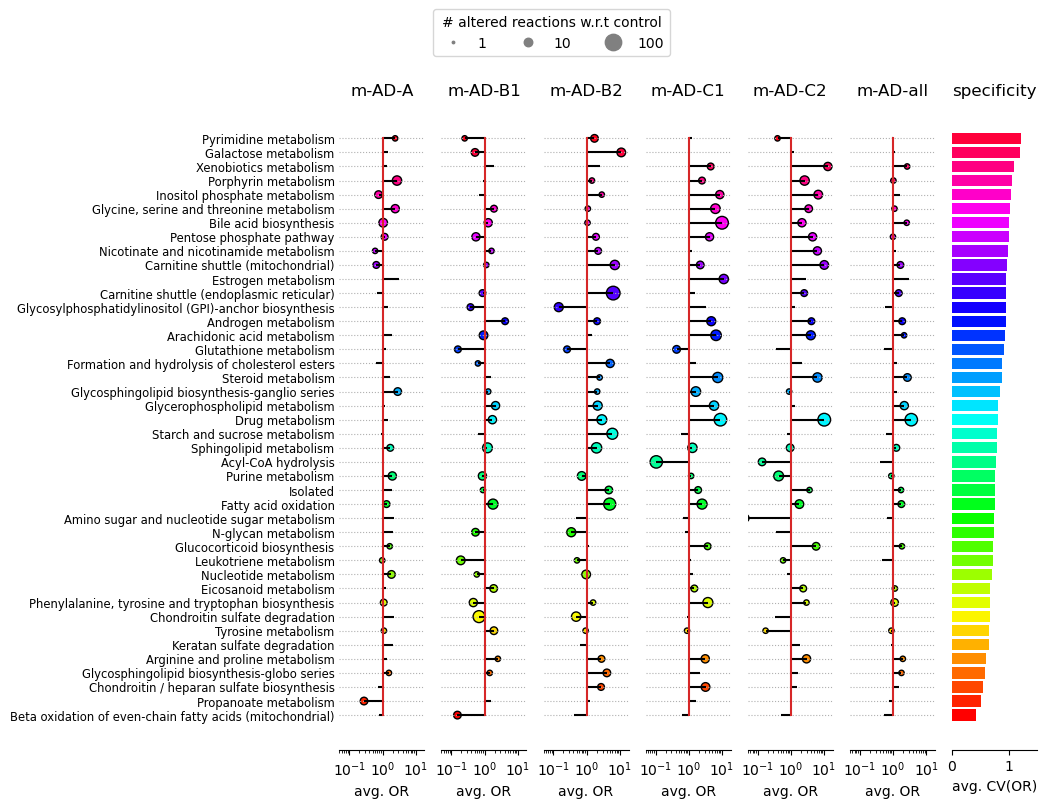

In [7]:
fig, ax = OR_subtype_plot(n_signif, OR)
attila_utils.savefig(fig, 'm-OR-subtype-FDR-None')

### At least 2 altered reactions with 5% Benjamini-Hochberg FDR control

['named-figure/m-OR-subtype.png', 'named-figure/m-OR-subtype.pdf']

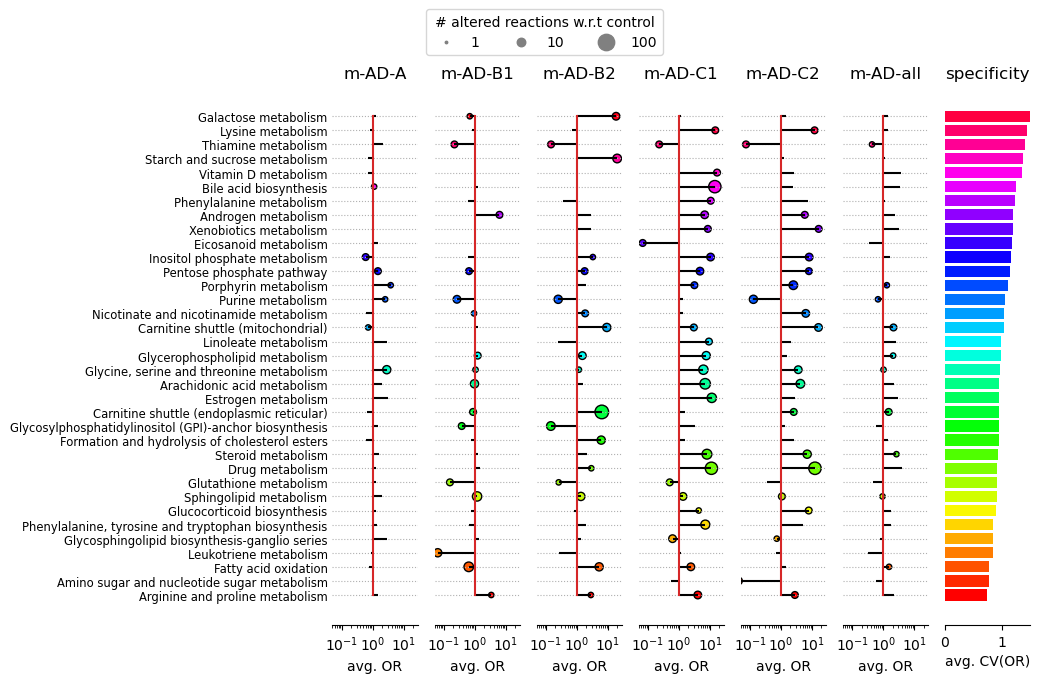

In [8]:
fig, ax = OR_subtype_plot(*process_n_signif(cohort='m', method=FDR_method, to_drop=subsystems_to_drop, min_signif=2))
attila_utils.savefig(fig, 'm-OR-subtype')

## ROSMAP cohort

### At least 3 altered reactions without FDR control

['named-figure/r-OR-subtype-FDR-None.png',
 'named-figure/r-OR-subtype-FDR-None.pdf']

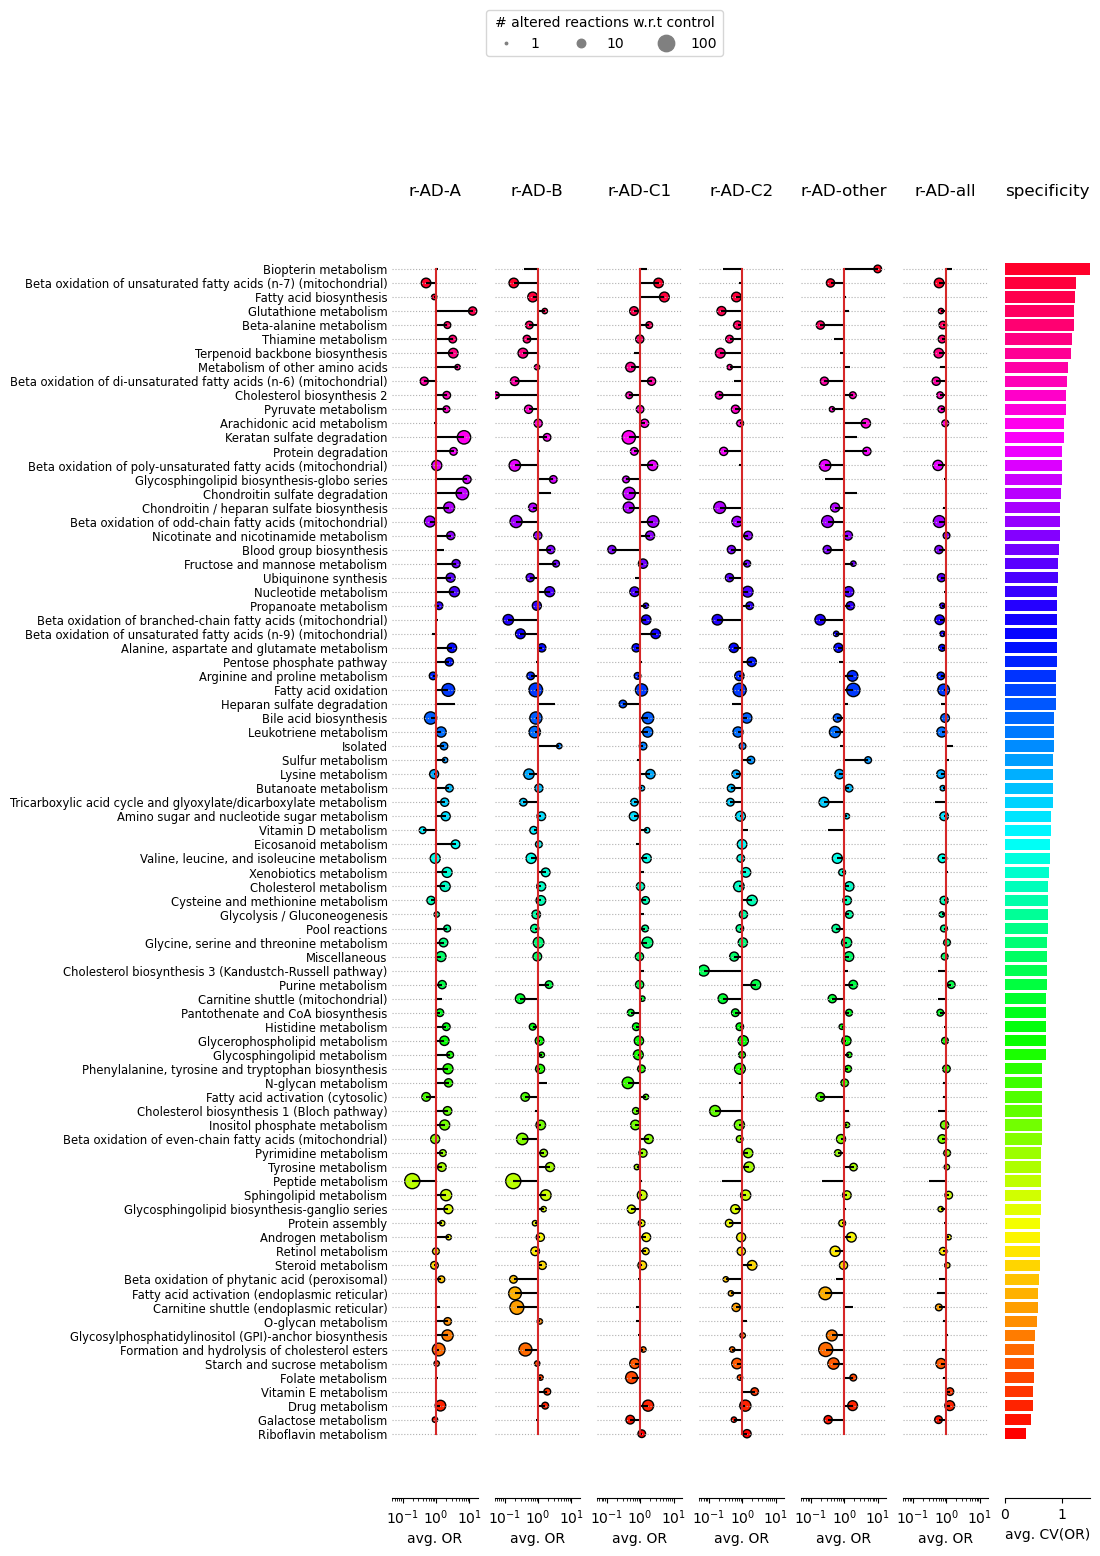

In [9]:
fig, ax = OR_subtype_plot(*process_n_signif(cohort='r', method=None, to_drop=subsystems_to_drop, min_signif=3))
attila_utils.savefig(fig, 'r-OR-subtype-FDR-None')

### At least 4 altered reactions with 5% Benjamini-Hochberg FDR control

['named-figure/r-OR-subtype.png', 'named-figure/r-OR-subtype.pdf']

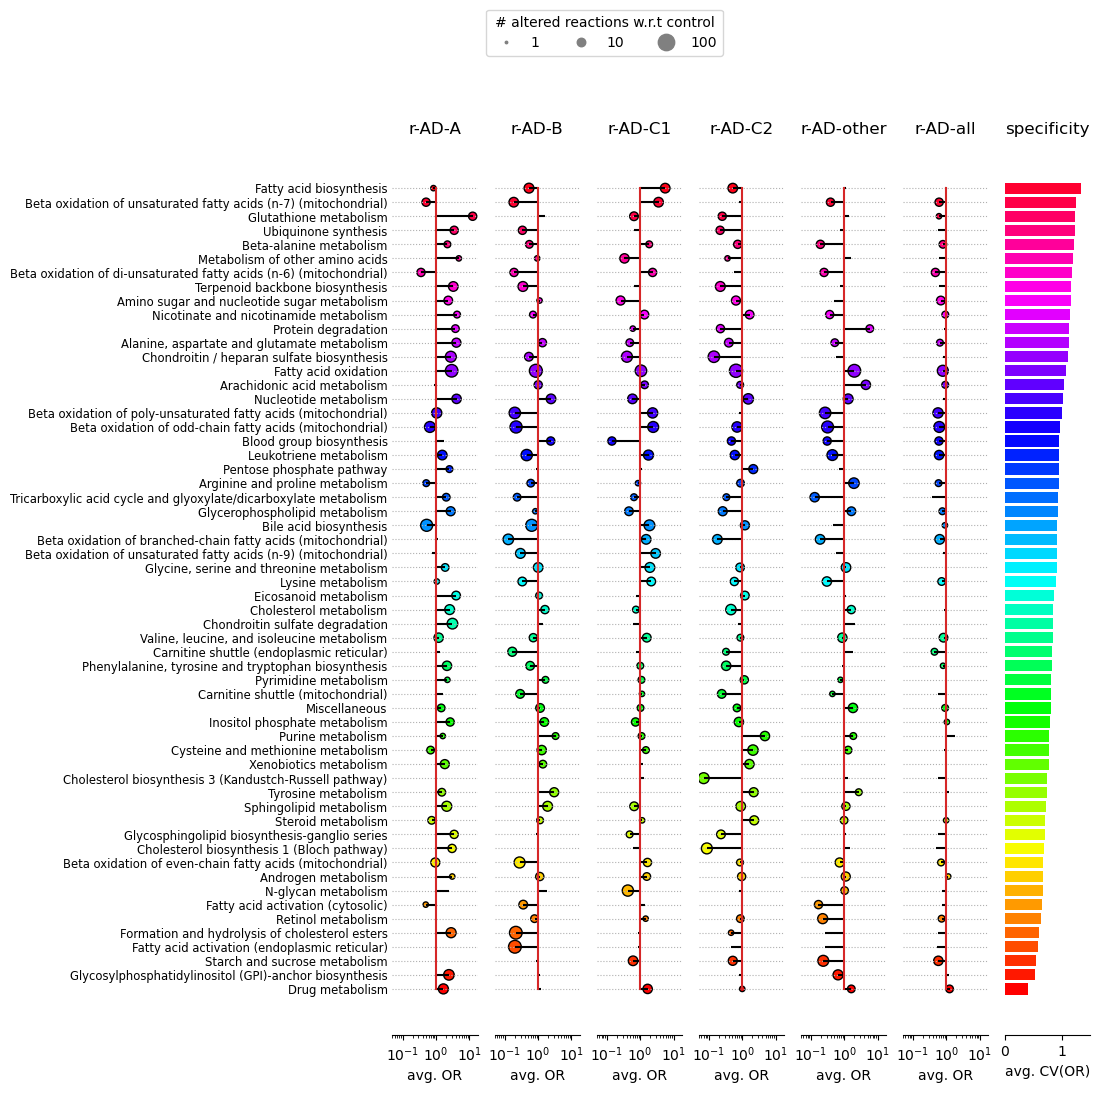

In [10]:
fig, ax = OR_subtype_plot(*process_n_signif(cohort='r', method=FDR_method, to_drop=subsystems_to_drop, min_signif=4))
attila_utils.savefig(fig, 'r-OR-subtype')

In [11]:
%connect_info

{
  "shell_port": 56822,
  "iopub_port": 56823,
  "stdin_port": 56824,
  "control_port": 56826,
  "hb_port": 56825,
  "ip": "127.0.0.1",
  "key": "9014305c-987e49d765d31fe815f09a55",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-45abd6a3-7757-4de3-a07d-b7a14a7adc5e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
